In [1]:
import os
import numpy as np

import random
random.seed(123)

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
torch.manual_seed(123);

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import transforms

import pytorch_lightning as pl

import cv2
from PIL import Image

%load_ext autoreload
%autoreload 1
%aimport utils_loss
%aimport metrics

from utils_loss import CustomLoss

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataloader

In [3]:
class UCF_VIDEOS_DATASET(torch.utils.data.Dataset):
    
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.annotation_array = [] # [video_path, anomaly_frame] if anomaly_frame == -1 normal_video
        with open(path_to_annotation, 'r') as fp:
            for line in fp:
                splited_line = line.split("  ")
                if(splited_line[1] == "Explosion"):
                    self.annotation_array.append([splited_line[0], int(splited_line[2])])
                if(splited_line[1] == "Normal"):
                    self.annotation_array.append([splited_line[0], -1])        
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.annotation_array) - 1
        
    def __getitem__(self, item_idx):
        sequence_imgs = []
        sequence_labels = []
        step_size = 4
        frame_block_iter = 0
        frame_block_iter_length = 0
        frame_counter = 0
        video_name = self.annotation_array[item_idx][0]
        video_anomaly_frame = self.annotation_array[item_idx][1]
        cap = cv2.VideoCapture(os.path.join(self.path_to_videos, video_name))
        total_video_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        preprocess = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 #transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])
        
        if video_anomaly_frame == -1:
            video_normal_frame = random.randint(int(total_video_frames / 4) , int(total_video_frames *3/4))
#             left_frames_length = video_normal_frame - 0
#             right_frames_length = total_video_frames - video_normal_frame
            start_frame = video_normal_frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    sequence_labels.append(0)
        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                if(frame_block_iter_length == self.seq_len): break
            
        if video_anomaly_frame != -1:
            left_frames_length = video_anomaly_frame - 0
            right_frames_length = total_video_frames - video_anomaly_frame
            # Если края меньше 4 секунд(В Explosion минимальная длина 9 секунд).
            # Так что максимальная длина 16 seq_len
            start_frame_delta = random.randint(0, ((self.seq_len - 1)  * step_size) - 1 ) + 1
            start_frame = video_anomaly_frame - start_frame_delta
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint(0, 19) + 1
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint((self.seq_len * step_size) - 20, (self.seq_len * step_size))
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            frame_counter = start_frame
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    if(frame_counter < video_anomaly_frame):
                         sequence_labels.append(0)
                    else:
                        sequence_labels.append(1)
                        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                frame_counter += 1
                #print(frame_block_iter_length)
                if(frame_block_iter_length == self.seq_len): break

        sequence_labels = np.asarray(sequence_labels)
        sequence_labels = torch.from_numpy(sequence_labels)

        sequence_imgs = torch.stack(sequence_imgs)
        
        return sequence_imgs, sequence_labels

# Models

In [19]:
HIDDEN_CNN = 100
HIDDEN_LSTM = HIDDEN_CNN // 2
#HIDDEN_LSTM = HIDDEN_CNN * 2

class FullyConnected(torch.nn.Module):
    def __init__(self, input_size=1280):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(input_size, HIDDEN_CNN)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, HIDDEN_CNN)


class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        
        self.cnn = mobile_net_v2
        #self.cnn = nn.Sequential(*list(mobile_net_v2.features.children())[:6])
        #self.classifier = FullyConnected(input_size=HIDDEN_CNN)
        self.classifier = mobile_net_v2.classifier

        self.rnn = nn.GRU(
            input_size=HIDDEN_CNN,  # 1280 if conv block mobile net used
            hidden_size=HIDDEN_LSTM, 
            num_layers=1,
            batch_first=True, 
            dropout=0.1)
        
        self.linear = nn.Linear(HIDDEN_LSTM, 1)      
        self.dropout = nn.Dropout(0.25)
        self.dropout_2 = nn.Dropout(0.5)        
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        #c_out = nn.functional.adaptive_avg_pool2d(c_out, (1, 1))
        #c_out = torch.flatten(c_out, 1)
        #c_out = self.classifier(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, _ = self.rnn(r_in)
        r_out = r_out.reshape(batch_size * timesteps, -1)
        r_out = self.dropout(self.linear(r_out).view(batch_size, timesteps, -1))
        out = self.activation(r_out)
        return out    
    
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)    
mobile_net_v2.classifier = FullyConnected()

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


# Pytorch Lightning

In [20]:
class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        batch_size: int = 16,
        seq_len: int = 16, 
        loss_type: str = 'bce',
        path_to_videos: str = "Explosion/",
        path_annotation_train: str = "UCF_train.txt",
        path_annotation_validation: str = "UCF_validation.txt",
        
    ):
        super(CPD_model, self).__init__()

        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = CustomLoss()
            
        self.imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, path_to_videos, 
                                                     seq_len=self.seq_len)
        self.imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, 
                                                          path_to_videos, seq_len=self.seq_len)        
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001) 
        return [opt]

    def train_dataloader(self):
        
        train_dataloader = DataLoader(self.imgs_dataset_train, batch_size=self.batch_size, shuffle=True)
        return train_dataloader
        
    
    def val_dataloader(self):
        
        val_dataloader = DataLoader(self.imgs_dataset_validation, batch_size=self.batch_size, shuffle=False)
        return val_dataloader

## Model BCE loss

In [21]:
model_bce = Combine()

# CNT = 157 if use all 

#for param in model_bce.cnn.parameters():
#    param.requires_grad = False

cnt = 0
for param in model_bce.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False
    
    
model_bce_pl = CPD_model(model=model_bce, batch_size=8, seq_len=16, loss_type='bce')    

experiment_name = 'bce_loss'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='min'
)

trainer_bce = pl.Trainer(
    max_epochs=40, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
%load_ext tensorboard 
%tensorboard --logdir logs --port 2021

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 2021 (pid 9966), started 4 days, 1:34:20 ago. (Use '!kill 9966' to kill it.)

In [23]:
trainer_bce.fit(model_bce_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 2.4 M 
1 | loss  | BCELoss | 0     
----------------------------------
150 K     Trainable params
2.2 M     Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric val_loss improved. New best score: 0.368


Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.322


Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.303


Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.284


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.275


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.266


Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.246


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.240


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.229


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.229. Signaling Trainer to stop.


## Model CUSTOM loss

In [24]:
model_custom = Combine()
#for param in model_custom.cnn.parameters():
#    param.requires_grad = False
    
cnt = 0
for param in model_custom.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False
    

    
model_custom_pl = CPD_model(model=model_custom, batch_size=8, 
                            seq_len=16, loss_type='custom')    



experiment_name = 'custom_loss'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=15,
   verbose=True,
   mode='min'
)

trainer_custom = pl.Trainer(
    max_epochs=100, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [25]:
trainer_custom.fit(model_custom_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Combine    | 2.4 M 
1 | loss  | CustomLoss | 0     
-------------------------------------
150 K     Trainable params
2.2 M     Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)


Metric val_loss improved. New best score: -1.997


Metric val_loss improved by 0.593 >= min_delta = 0.01. New best score: -2.590


Metric val_loss improved by 0.336 >= min_delta = 0.01. New best score: -2.926


Metric val_loss improved by 0.149 >= min_delta = 0.01. New best score: -3.075


Metric val_loss improved by 0.093 >= min_delta = 0.01. New best score: -3.168


Metric val_loss improved by 0.395 >= min_delta = 0.01. New best score: -3.563


Metric val_loss improved by 0.257 >= min_delta = 0.01. New best score: -3.820


Metric val_loss improved by 0.230 >= min_delta = 0.01. New best score: -4.049


Metric val_loss improved by 0.103 >= min_delta = 0.01. New best score: -4.152


Metric val_loss improved by 0.055 >= min_delta = 0.01. New best score: -4.207


Metric val_loss improved by 0.358 >= min_delta = 0.01. New best score: -4.565


Metric val_loss improved by 0.377 >= min_delta = 0.01. New best score: -4.942


Metric val_loss improved by 0.181 >= min_delta = 0.01. New best score: -5.122


Metric val_loss improved by 0.372 >= min_delta = 0.01. New best score: -5.495


Monitored metric val_loss did not improve in the last 15 records. Best score: -5.495. Signaling Trainer to stop.


In [26]:
val_loader = model_custom_pl.val_dataloader()

##### Model COMBINED loss

In [28]:
model_combined = Combine()
#for param in model_combined.cnn.parameters():
#    param.requires_grad = False    

    
cnt = 0
for param in model_custom.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False

    
experiment_name = 'combined'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


model_combined_pl_1 = CPD_model(model=model_combined, batch_size=8, seq_len=16, loss_type='bce')    

trainer_combined_1 = pl.Trainer(
    max_epochs=20, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [29]:
trainer_combined_1.fit(model_combined_pl_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 2.4 M 
1 | loss  | BCELoss | 0     
----------------------------------
150 K     Trainable params
2.2 M     Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)


In [30]:
model_combined_pl_2 = CPD_model(model=model_combined_pl_1.model.to(device), batch_size=16, seq_len=16, loss_type='custom')    

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.01,
   patience=10,
   verbose=True,
   mode='min'
)

trainer_combined_2 = pl.Trainer(
    max_epochs=50, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback_2, early_stop_callback])   

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [31]:
trainer_combined_2.fit(model_combined_pl_2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Combine    | 2.4 M 
1 | loss  | CustomLoss | 0     
-------------------------------------
150 K     Trainable params
2.2 M     Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)


Metric val_acc improved. New best score: 0.777


Monitored metric val_acc did not improve in the last 10 records. Best score: 0.777. Signaling Trainer to stop.


## Get Pareto Metric

In [49]:
%aimport metrics_v3

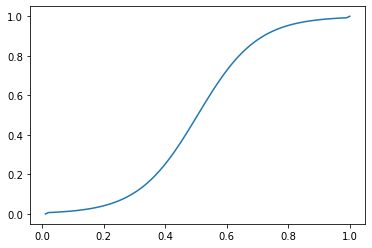

In [50]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = list(1 / (1 + np.exp(-threshold_list)))
threshold_list = [-0.0001] + threshold_list + [1.001] 
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [51]:
%aimport metrics_v3

In [52]:
val_loader = model_bce_pl.val_dataloader()

In [53]:
model_bce_pl.model.to(device)
_, _, delay_list_bce, fp_delay_list_bce = metrics_v3.get_pareto_metrics_for_threshold(model_bce_pl.model, val_loader, 8, 16, threshold_list)
print("BCE")

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 F

In [54]:
model_combined_pl_2.model.to(device)
_, _, delay_list_combined, fp_delay_list_combined = metrics_v3.get_pareto_metrics_for_threshold(model_combined_pl_2.model, val_loader, 8, 16, threshold_list)
print("COMBINED")

TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.056818181818181816
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.4318181818181818
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.8977272727272727
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 1.2159090909090908
TP: 1 TN: 0 FP: 87 FN: 0 DELAY: 0.0 FP_DELAY 1.7840909090909092
TP: 1 TN: 0 FP: 87 FN: 0 DELAY: 0.0 FP_DELAY 2.159090909090909
TP: 3 TN: 1 FP: 84 FN: 0 DELAY: 0.011363636363636364 FP_DELAY 2.8181818181818183
TP: 3 TN: 0 FP: 85 FN: 0 DELAY: 0.03409090909090909 FP_DELAY 3.397727272727273
TP: 3 TN: 2 FP

In [55]:
model_custom_pl.model.to(device)
_, _, delay_list_custom, fp_delay_list_custom = metrics_v3.get_pareto_metrics_for_threshold(model_custom_pl.model, val_loader, 8, 16, threshold_list)
print("CUSTOM")

TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.045454545454545456
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.09090909090909091
TP: 0 TN: 0 FP: 88 FN: 0 DELAY: 0.0 FP_DELAY 0.17045454545454544
TP: 2 TN: 0 FP: 86 FN: 0 DELAY: 0.0 FP_DELAY 0.29545454545454547
TP: 1 TN: 0 FP: 87 FN: 0 DELAY: 0.011363636363636364 

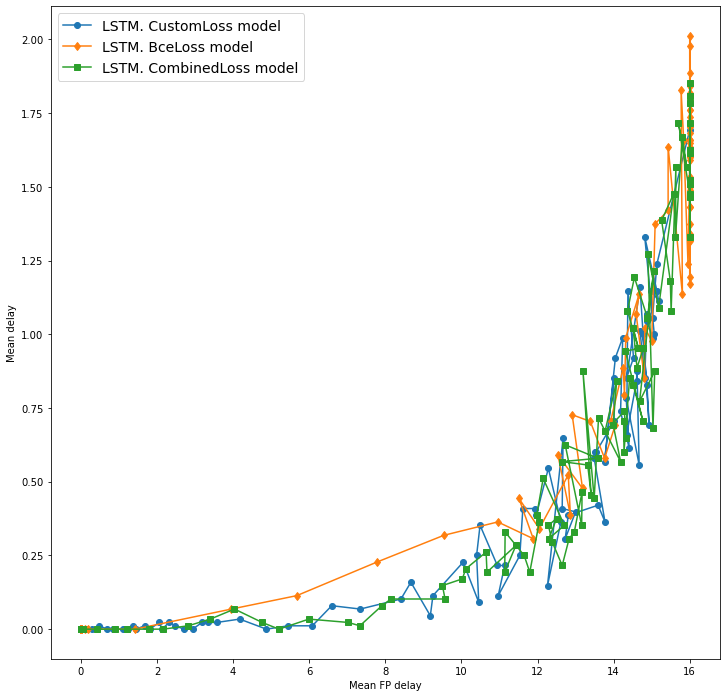

In [56]:
# with_lin_space
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_custom, delay_list_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='LSTM. BceLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='LSTM. CombinedLoss model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

In [84]:
import pandas as pd
fp_delay_list_custom_rolling = pd.Series(fp_delay_list_custom).rolling(5).mean()
delay_list_custom_rolling = pd.Series(delay_list_custom).rolling(5).mean()
fp_delay_list_bce_rolling = pd.Series(fp_delay_list_bce).rolling(5).mean()
delay_list_bce_rolling = pd.Series(delay_list_bce).rolling(5).mean()
fp_delay_list_combined_rolling = pd.Series(fp_delay_list_combined).rolling(5).mean()
delay_list_combined_rolling = pd.Series(delay_list_combined).rolling(5).mean()

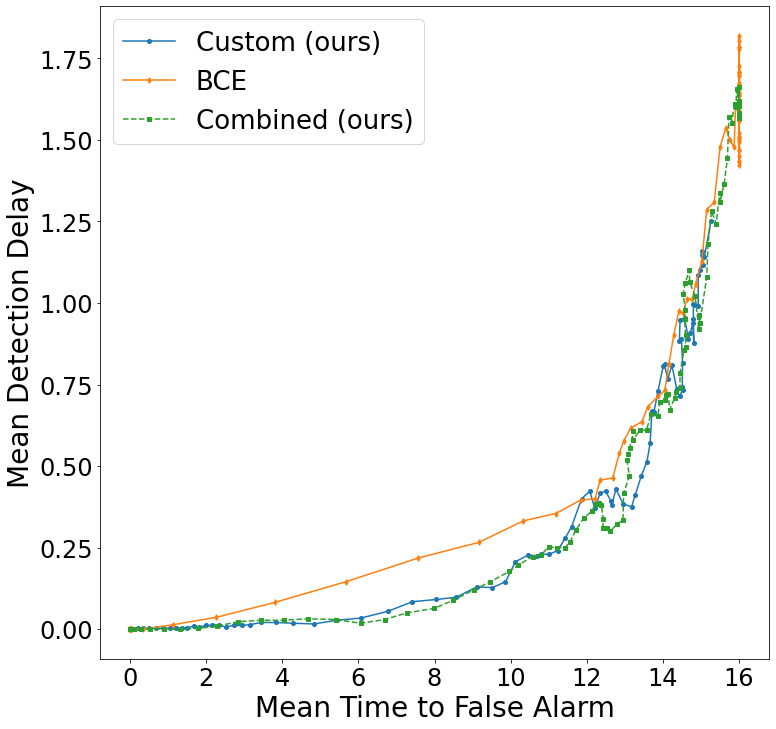

In [116]:
# with_lin_space
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_custom_rolling, delay_list_custom_rolling, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_bce_rolling, delay_list_bce_rolling, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_combined_rolling, delay_list_combined_rolling, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('explosion_curve.pdf', bbox_inches='tight')

In [57]:
%aimport metrics_v3

In [281]:
metrics_v3.save_metrics_to_file_new_version('Custom', model_custom_pl.model, val_loader, batch_size=8,
                                            seq_len=16, fp_delay=fp_delay_list_custom, threshold_list=threshold_list, 
                                            x_coord_arr=[8, 9, 10, 11, 12, 13, 14, 15], path_to_save = "")

7.340909090909091 0.27695909778815886 8.409090909090908 0.29763488497442225 8


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 6 TN: 21 FP: 61 FN: 0 DELAY: 0.03409090909090909 FP_DELAY 8.079545454545455
8.670454545454545 0.31917282672147035 9.181818181818182 0.34151151059747936 9
TP: 8 TN: 27 FP: 53 FN: 0 DELAY: 0.125 FP_DELAY 8.659090909090908
9.25 0.3645764407416393 10.045454545454545 0.3882805885928385 10
TP: 7 TN: 36 FP: 44 FN: 1 DELAY: 0.125 FP_DELAY 10.090909090909092
10.965909090909092 0.537806489073151 11.534090909090908 0.5627979536943825 11
TP: 8 TN: 45 FP: 32 FN: 3 DELAY: 0.23863636363636365 FP_DELAY 11.511363636363637
11.965909090909092 0.6354235592583607 12.284090909090908 0.6584884894025207 12
TP: 10 TN: 48 FP: 27 FN: 3 DELAY: 0.38636363636363635 FP_DELAY 12.272727272727273
13.0 0.7616262557896033 12.727272727272727 0.7794778729544305 13
TP: 8 TN: 53 FP: 21 FN: 6 DELAY: 0.3522727272727273 FP_DELAY 13.0
14.0 0.888023290380253 13.761363636363637 0.8976807964919297 14
TP: 8 TN: 62 FP: 10 FN: 8 DELAY: 0.9659090909090909 FP_DELAY 14.056818181818182
14.988636363636363 0.9918210571437178 15.02272727

In [282]:
metrics_v3.area_under_graph(delay_list_custom, fp_delay_list_custom)


4.353499483471074

In [283]:
metrics_v3.save_metrics_to_file_new_version('BCE', model_bce_pl.model, val_loader, batch_size=8,
                                            seq_len=16, fp_delay=fp_delay_list_bce, threshold_list=threshold_list, 
                                            x_coord_arr=[8, 9, 10, 11, 12, 13, 14, 15], path_to_save = "")

7.7727272727272725 0.12242143898621305 9.534090909090908 0.13369373589385355 8
TP: 3 TN: 41 FP: 41 FN: 3 DELAY: 0.38636363636363635 FP_DELAY 8.579545454545455
7.7727272727272725 0.12242143898621305 9.534090909090908 0.13369373589385355 9
TP: 4 TN: 41 FP: 38 FN: 5 DELAY: 0.19318181818181818 FP_DELAY 9.329545454545455
9.534090909090908 0.13369373589385355 10.954545454545455 0.14583148353491507 10
TP: 6 TN: 45 FP: 32 FN: 5 DELAY: 0.3522727272727273 FP_DELAY 10.170454545454545
10.954545454545455 0.14583148353491507 11.886363636363637 0.15886910488091516 11
TP: 6 TN: 53 FP: 24 FN: 5 DELAY: 0.22727272727272727 FP_DELAY 11.420454545454545
11.511363636363637 0.17283646446618905 12.045454545454545 0.18775768905482057 12
TP: 10 TN: 59 FP: 14 FN: 5 DELAY: 0.5454545454545454 FP_DELAY 12.75
12.909090909090908 0.27695909778815886 13.386363636363637 0.29763488497442225 13
TP: 8 TN: 62 FP: 11 FN: 7 DELAY: 0.6704545454545454 FP_DELAY 13.386363636363637
13.761363636363637 0.31917282672147035 14.04545454

In [284]:
metrics_v3.area_under_graph(delay_list_bce, fp_delay_list_bce)

5.404313016528926

In [285]:
metrics_v3.save_metrics_to_file_new_version('Combine', model_combined_pl_2.model, val_loader, batch_size=8,
                                            seq_len=16, fp_delay=fp_delay_list_combined, threshold_list=threshold_list, 
                                            x_coord_arr=[8, 9, 10, 11, 12, 13, 14, 15], path_to_save = "")

7.909090909090909 0.0585369028743679 8.147727272727273 0.06435824095339865 8
TP: 3 TN: 23 FP: 62 FN: 0 DELAY: 0.03409090909090909 FP_DELAY 8.284090909090908
9.568181818181818 0.07071501202714367 9.5 0.07764754608342478 9
TP: 7 TN: 44 FP: 33 FN: 4 DELAY: 0.06818181818181818 FP_DELAY 11.170454545454545
9.5 0.07764754608342478 10.022727272727273 0.08519740106158838 10
TP: 4 TN: 38 FP: 44 FN: 2 DELAY: 0.1590909090909091 FP_DELAY 10.272727272727273
11.431818181818182 0.12242143898621305 11.136363636363637 0.13369373589385355 11
TP: 7 TN: 42 FP: 37 FN: 2 DELAY: 0.14772727272727273 FP_DELAY 11.068181818181818
11.977272727272727 0.20364993350221924 12.147727272727273 0.2205221270455694 12
TP: 7 TN: 49 FP: 28 FN: 4 DELAY: 0.3522727272727273 FP_DELAY 11.931818181818182
12.965909090909092 0.3882805885928385 13.170454545454545 0.4125253704018182 13
TP: 10 TN: 55 FP: 18 FN: 5 DELAY: 0.625 FP_DELAY 12.215909090909092
13.988636363636363 0.6808271732785297 14.079545454545455 0.7023651150255775 14
TP: 

In [286]:
metrics_v3.area_under_graph(delay_list_combined, fp_delay_list_combined)

4.121900826446281

In [313]:
batch.shape

torch.Size([8, 16, 3, 224, 224])

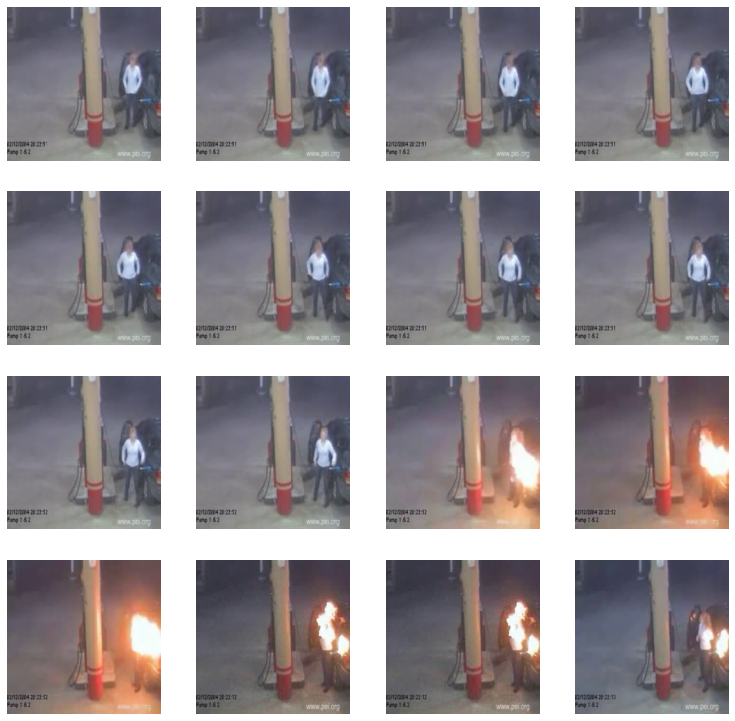

In [314]:
IM_SIZE = 224
i = 0
fig, axs = plt.subplots(4, 4, figsize=(13, 13))
# for ind in range(seq_len):
for index in range(16):
    first_index = int(index / 4)
    second_index = index % 4
    axs[first_index, second_index].set_axis_off()
    axs[first_index, second_index].imshow(batch[i][index].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.savefig('explosion_change.pdf', bbox_inches='tight')

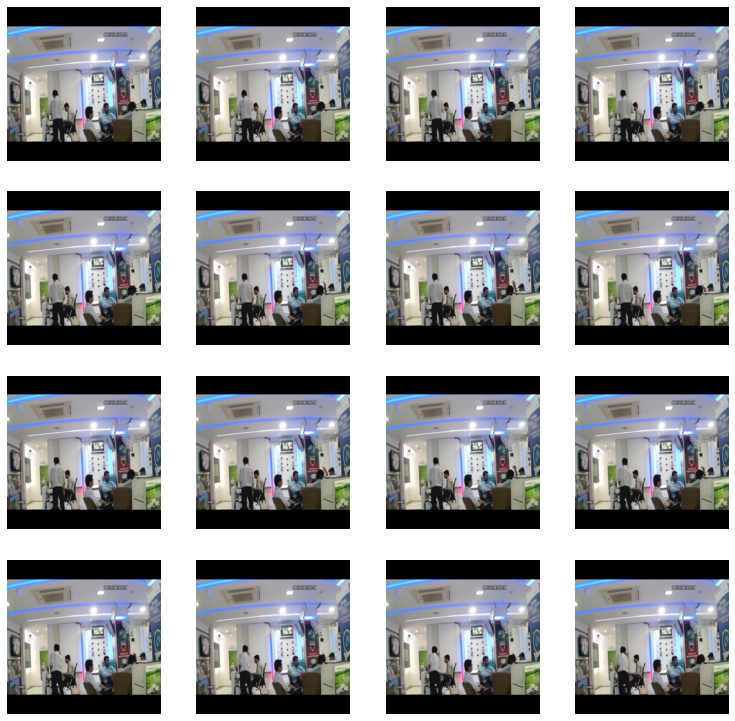

In [315]:
IM_SIZE = 224
i = 7
fig, axs = plt.subplots(4, 4, figsize=(13, 13))
# for ind in range(seq_len):
for index in range(16):
    first_index = int(index / 4)
    second_index = index % 4
    axs[first_index, second_index].set_axis_off()
    axs[first_index, second_index].imshow(batch[i][index].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.savefig('explosion_normal.pdf', bbox_inches='tight')

# Figures

In [237]:
batch, labels = next(iter(val_loader))
batch = batch.to(device)

In [238]:
pred_bce = model_bce_pl(batch)
pred_custom = model_custom_pl(batch)
pred_comb = model_combined_pl_2(batch)

In [239]:
display(pred_bce[0].flatten())
display(pred_custom[0].flatten())
display(pred_comb[0].flatten())
display(labels[0].flatten())

tensor([0.0774, 0.0675, 0.0608, 0.0580, 0.0562, 0.0575, 0.0515, 0.0530, 0.0587,
        0.0611, 0.0665, 0.4354, 0.4697, 0.5169, 0.5421, 0.5175],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0.0240, 0.0381, 0.0597, 0.0861, 0.1083, 0.1351, 0.1505, 0.1731, 0.1965,
        0.2200, 0.2894, 0.9813, 0.9820, 0.9863, 0.9874, 0.9777],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0.0151, 0.0164, 0.0169, 0.0175, 0.0186, 0.0204, 0.0211, 0.0224, 0.0252,
        0.0285, 0.0336, 0.9331, 0.9341, 0.9467, 0.9475, 0.9356],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

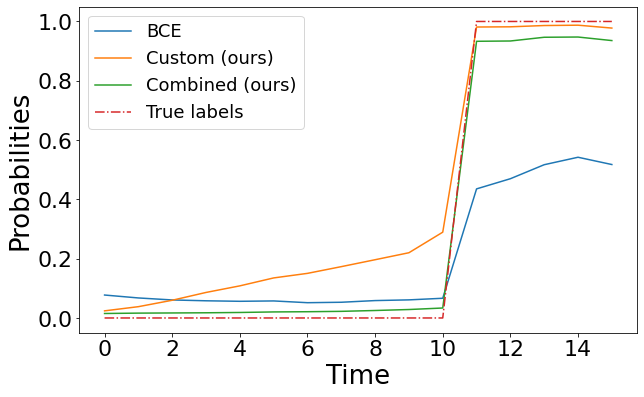

In [240]:
i = 0
plt.figure(figsize=(10, 6))
plt.plot(pred_bce[i].detach().cpu().numpy(), label='BCE')
plt.plot(pred_custom[i].detach().cpu().numpy(), label='Custom (ours)')
plt.plot(pred_comb[i].detach().cpu().numpy(), label='Combined (ours)')
plt.plot(labels[i], '-.', label='True labels')
plt.xlabel('Time', fontsize=26)
plt.ylabel('Probabilities', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18);
plt.savefig('good_example_predictions.pdf', bbox_inches='tight')

In [566]:
batch, labels = next(iter(val_loader))
batch = batch.to(device)

pred_bce = model_bce_pl(batch)
pred_custom = model_custom_pl(batch)
pred_comb = model_combined_pl_2(batch)

In [569]:
display(pred_bce[7].flatten())
display(pred_custom[7].flatten())
display(pred_comb[7].flatten())
display(labels[7].flatten())

tensor([0.1064, 0.0888, 0.0883, 0.0894, 0.0882, 0.0864, 0.0887, 0.0889, 0.0892,
        0.0886, 0.0921, 0.0925, 0.0911, 0.0890, 0.0906, 0.0909],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0.0326, 0.0400, 0.0747, 0.1256, 0.1836, 0.2302, 0.2710, 0.2999, 0.3192,
        0.3272, 0.3448, 0.3590, 0.3639, 0.3597, 0.3707, 0.3823],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0.0158, 0.0187, 0.0227, 0.0273, 0.0318, 0.0357, 0.0412, 0.0459, 0.0501,
        0.0532, 0.0590, 0.0653, 0.0677, 0.0680, 0.0710, 0.0744],
       device='cuda:0', grad_fn=<ViewBackward>)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

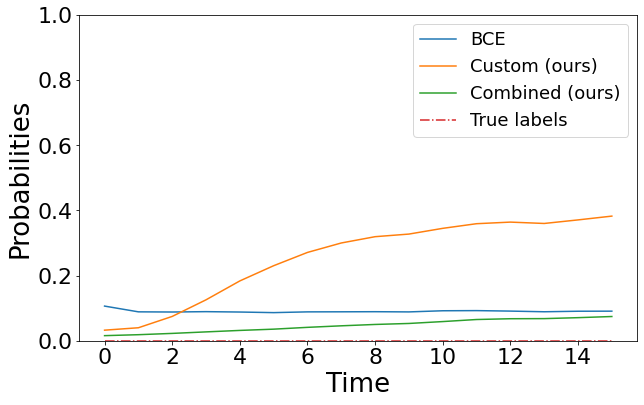

In [572]:
i = 7
plt.figure(figsize=(10, 6))
plt.plot(pred_bce[i].detach().cpu().numpy(), label='BCE')
plt.plot(pred_custom[i].detach().cpu().numpy(), label='Custom (ours)')
plt.plot(pred_comb[i].detach().cpu().numpy(), label='Combined (ours)')
plt.plot(labels[i], '-.', label='True labels')
plt.xlabel('Time', fontsize=26)
plt.ylabel('Probabilities', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18);
plt.ylim(0, 1)
plt.savefig('bad_example_predictions.pdf', bbox_inches='tight')

In [274]:
batch, labels = next(iter(val_loader))
batch = batch.to(device)

pred_bce = model_bce_pl(batch)
pred_custom = model_custom_pl(batch)
pred_comb = model_combined_pl_2(batch)

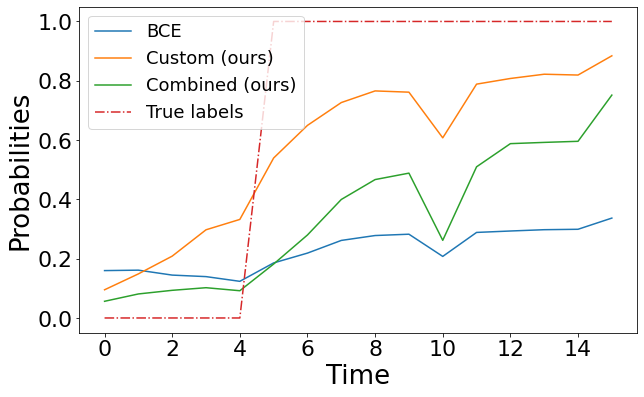

In [279]:
i = 3
plt.figure(figsize=(10, 6))
plt.plot(pred_bce[i].detach().cpu().numpy(), label='BCE')
plt.plot(pred_custom[i].detach().cpu().numpy(), label='Custom (ours)')
plt.plot(pred_comb[i].detach().cpu().numpy(), label='Combined (ours)')
plt.plot(labels[i], '-.', label='True labels')
plt.xlabel('Time', fontsize=26)
plt.ylabel('Probabilities', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18);
plt.savefig('good_example_predictions_2.pdf', bbox_inches='tight')

# TSNE

In [401]:
all_outputs = []
all_labels = []

model_custom_pl.eval()
cnn = model_custom_pl.model.cnn
rnn = model_custom_pl.model.rnn

    
for batch, labels in val_loader:
    batch = batch.to(device)
    batch_size, timesteps, C, H, W = batch.size()
    c_in = batch.view(batch_size * timesteps, C, H, W)
    c_out = cnn(c_in)
    r_in = c_out.view(batch_size, timesteps, -1)
    r_out, _ = rnn(r_in)
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)

In [412]:
all_outputs = np.concatenate(all_outputs, 0)
all_labels = np.concatenate(all_labels, 0)

In [413]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(all_outputs)

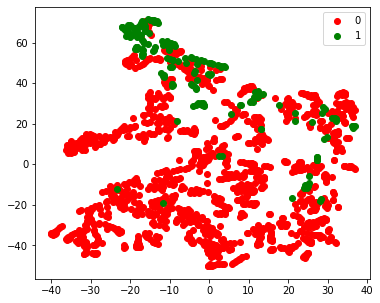

In [425]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g',
for i, c, label in zip(range(2), colors, np.unique(all_labels)):
    plt.scatter(embedding[all_labels == i, 0], embedding[all_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [426]:
all_outputs = []
all_labels = []

model_custom_pl.eval()
cnn = model_bce_pl.model.cnn
rnn = model_bce_pl.model.rnn

    
for batch, labels in val_loader:
    batch = batch.to(device)
    batch_size, timesteps, C, H, W = batch.size()
    c_in = batch.view(batch_size * timesteps, C, H, W)
    c_out = cnn(c_in)
    r_in = c_out.view(batch_size, timesteps, -1)
    r_out, _ = rnn(r_in)
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)

In [428]:
all_outputs = np.concatenate(all_outputs, 0)
all_labels = np.concatenate(all_labels, 0)

In [429]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(all_outputs)

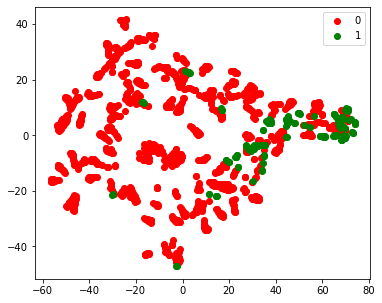

In [430]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g',
for i, c, label in zip(range(2), colors, np.unique(all_labels)):
    plt.scatter(embedding[all_labels == i, 0], embedding[all_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [431]:
all_outputs = []
all_labels = []

model_custom_pl.eval()
cnn = model_combined_pl_2.model.cnn
rnn = model_combined_pl_2.model.rnn

    
for batch, labels in val_loader:
    batch = batch.to(device)
    batch_size, timesteps, C, H, W = batch.size()
    c_in = batch.view(batch_size * timesteps, C, H, W)
    c_out = cnn(c_in)
    r_in = c_out.view(batch_size, timesteps, -1)
    r_out, _ = rnn(r_in)
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)

In [432]:
all_outputs = np.concatenate(all_outputs, 0)
all_labels = np.concatenate(all_labels, 0)

In [433]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(all_outputs)

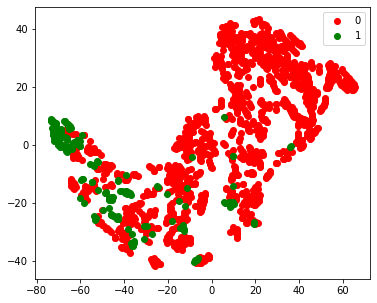

In [434]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g',
for i, c, label in zip(range(2), colors, np.unique(all_labels)):
    plt.scatter(embedding[all_labels == i, 0], embedding[all_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

# HIST

In [436]:
import seaborn as sns

In [460]:
bce = []
custom = []
combined = []
labels = []

for batch, lab in val_loader:
    batch = batch.to(device)
    pred_bce = model_bce_pl.model(batch).flatten().detach().cpu().numpy()
    pred_custom = model_custom_pl.model(batch).flatten().detach().cpu().numpy()
    pred_comb = model_combined_pl_2.model(batch).flatten().detach().cpu().numpy()
    bce.extend(pred_bce)
    custom.extend(pred_custom)
    combined.extend(pred_comb)
    labels.extend(lab.flatten().detach().cpu().numpy())

In [461]:
predictions = pd.DataFrame([bce, custom, combined, labels]).T
predictions.columns=['BCE', 'CUSTOM', 'COMBINED', 'LABELS']

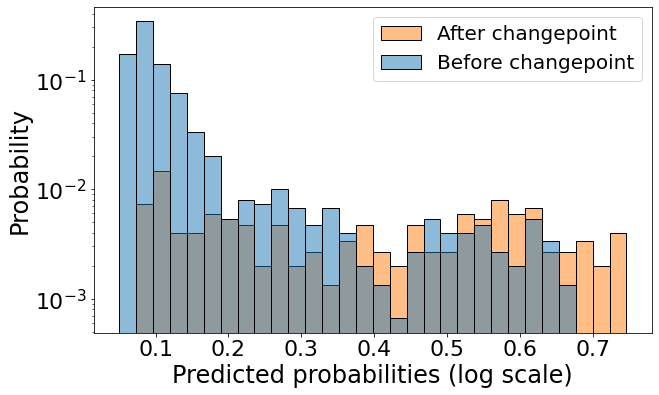

In [590]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=predictions, x='BCE', hue='LABELS', ax=ax, bins=30, stat='probability')
plt.legend(['After changepoint', 'Before changepoint'], fontsize=20)
plt.xlabel('Predicted probabilities (log scale)', fontsize=24);
plt.ylabel('Probability', fontsize=24);
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
ax.set_yscale('log')
plt.savefig('explosion_hist_bce.pdf', bbox_inches='tight')

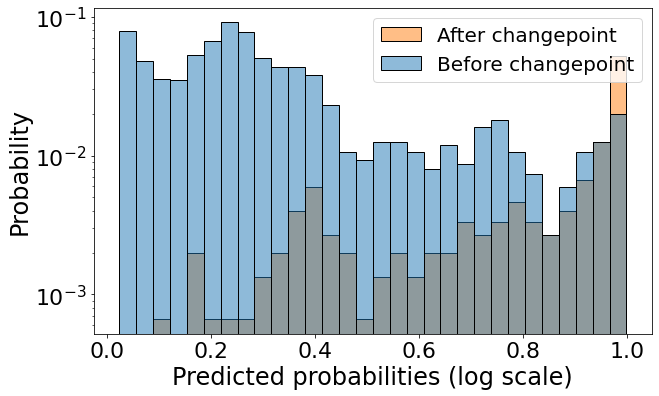

In [588]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=predictions, x='CUSTOM', hue='LABELS', ax=ax, bins=30, stat='probability')
plt.legend(['After changepoint', 'Before changepoint'], fontsize=20)
plt.xlabel('Predicted probabilities (log scale)', fontsize=24);
plt.ylabel('Probability', fontsize=24);
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
ax.set_yscale('log')
plt.savefig('explosion_hist_custom.pdf', bbox_inches='tight')

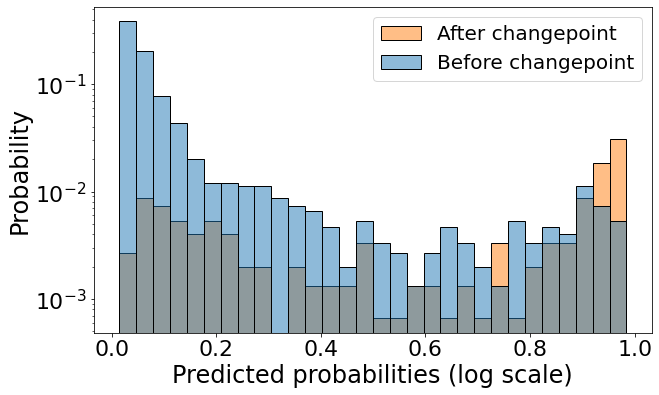

In [585]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=predictions, x='COMBINED', hue='LABELS', ax=ax, bins=30, stat='probability')
plt.legend(['After changepoint', 'Before changepoint'], fontsize=20)
plt.xlabel('Predicted probabilities (log scale)', fontsize=24);
plt.ylabel('Probability', fontsize=24);
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
ax.set_yscale('log')
plt.savefig('explosion_hist_comb.pdf', bbox_inches='tight')